In [1]:
from db_utils import *
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from lifelines import KaplanMeierFitter 
import numpy as np


Using pure Python version of concordance index. 
You can speed this up 100x by compiling the Fortran code with:
>>> python setup.py build_ext --inplace


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [3]:
query = """
SELECT start_date, end_date, receive_date, total_amount,source, contribution_recur_id, c.trxn_id
FROM civicrm.civicrm_contribution_recur cr JOIN civicrm.civicrm_contribution c ON c.contribution_recur_id = cr.id
"""
d = query_lutetium(query, {})

In [4]:
d.head()

,contribution_recur_id,end_date,receive_date,source,start_date,total_amount,trxn_id
0,5074,2012-05-20 17:28:00,2012-04-20 12:03:15,USD 5.00,2011-05-20 15:59:58,5.00,RECURRING PAYPAL 7W286566M0613580J 1334923467
1,5075,2012-05-23 18:34:00,2012-04-23 13:15:54,USD 10.00,2011-05-23 04:28:30,10.00,RECURRING PAYPAL 4GR13810KL282700S 1335186985
2,5076,2012-05-23 18:31:02,2012-04-23 13:05:58,USD 10.00,2011-05-23 13:45:35,10.00,RECURRING PAYPAL 3J8136101V394013U 1335186445
3,5077,2012-05-23 18:01:01,2012-04-23 11:39:23,USD 5.00,2011-05-23 15:36:26,5.00,RECURRING PAYPAL 0XS07875H2813131D 1335181225
4,5078,2012-05-23 18:16:00,2012-04-23 12:26:30,USD 25.00,2011-05-23 20:53:39,25.00,RECURRING PAYPAL 54353352C0112190V 1335184107


In [5]:
d['processor'] = 'other'

In [6]:
d.loc[d['trxn_id'].apply(lambda x: 'RECURRING PAYPAL' in x ), 'processor'] = 'paypal'
d.loc[d['trxn_id'].apply(lambda x: 'RECURRING AMAZON' in x ), 'processor'] = 'amazon'
d.loc[d['trxn_id'].apply(lambda x: 'RECURRING COINBASE' in x ), 'processor'] = 'coinbase'
d.loc[d['trxn_id'].apply(lambda x: 'GLOBALCOLLECT' in x ), 'processor'] = 'globalcollect'

In [7]:
# lets see what payment processors we missed
set(d['trxn_id'][d['processor']=='other'])

set()

In [8]:
# lets count the number of payments from each vendor
d.groupby(d['processor']).apply(lambda x: x.shape[0])

processor
amazon               57
coinbase             93
globalcollect    561830
paypal           555110
dtype: int64

In [9]:
# group individual payments into subscriptions
def group(df):
    r = df.iloc[0][['contribution_recur_id', 'end_date', 'start_date', 'total_amount', 'processor']]
    r['num_payments'] = df.shape[0]
    r['min_pay_date'] = str(df['receive_date'].min())
    r['max_pay_date'] = str(df['receive_date'].max())
    return r

ds = d.groupby('contribution_recur_id').apply(group)

In [10]:
# remove records where the start date is on a day prior to the first payment:
correct_start = ds['start_date'].apply(lambda x: str(x)[:10]) == ds['min_pay_date'].apply(lambda x: str(x)[:10])
ds = ds[correct_start]

In [30]:
# If oldest payment is from more than a month ago, declare the recurring payment terminated
ds['terminated'] = ds['max_pay_date'] < '2015-08-08 17:36:45'

In [31]:
def estimate_survival(d, processor=None, plot = True):
    if processor:
        d = d[d['processor'] == processor]
    T = d['num_payments']
    E = d['terminated']
    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=E) # more succiently, kmf.fit(T,E)
    print("Median Number of months before termination: %d" %kmf.median_)
    if plot:
        kmf.plot()
        plt.title("Recurring Payments Survival Function")
        plt.xlabel('number of months')
        plt.ylabel('probability of recurring more than t months')

Median Number of months before termination: 14


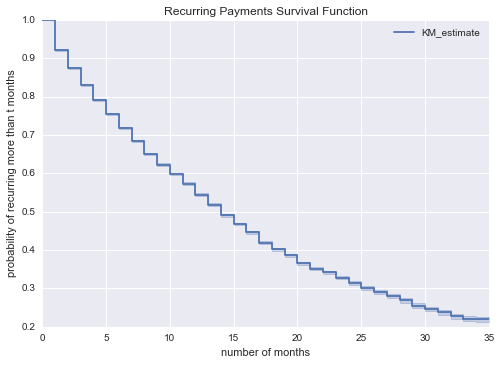

In [32]:
estimate_survival(ds, processor=None)

Median Number of months before termination: 19


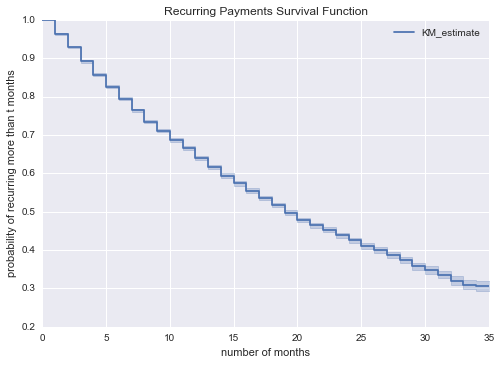

In [33]:
estimate_survival(ds, processor='paypal')

Median Number of months before termination: 12


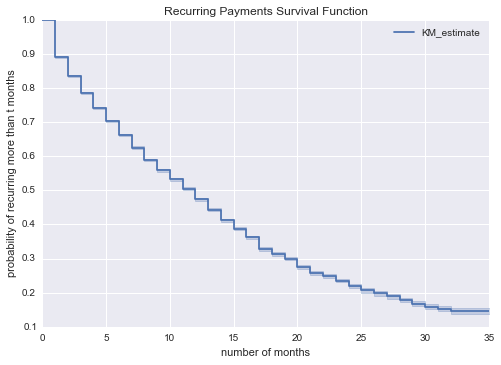

In [34]:
estimate_survival(ds, processor='globalcollect')

Median Number of months before termination: 1


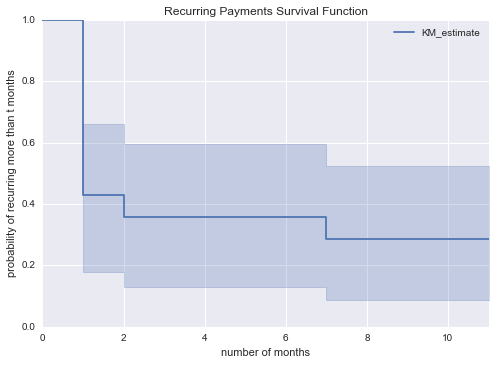

In [35]:
estimate_survival(ds, processor='amazon')

Median Number of months before termination: 2


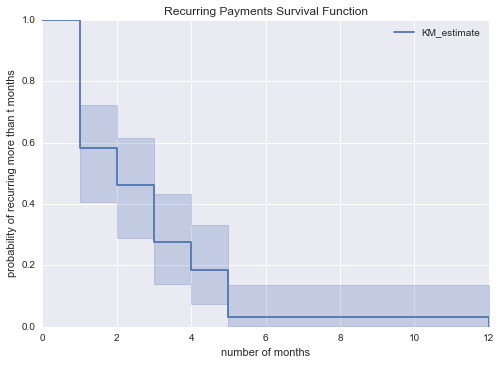

In [36]:
estimate_survival(ds, processor='coinbase')

In [37]:
# Number of subscriptions per processor
ds.groupby(ds['processor']).apply(lambda x: x.shape[0])

processor
amazon              14
coinbase            36
globalcollect    63584
paypal           45854
dtype: int64

In [38]:
# Median recurring amount per processor
ds['total_amount'].groupby(ds['processor']).apply(np.median)

processor
amazon           5.00
coinbase         5.00
globalcollect    5.00
paypal           4.43
dtype: object

In [39]:
# Average recurring amount per processor
ds['total_amount'].groupby(ds['processor']).apply(np.mean)

processor
amazon           9.571429
coinbase         7.148056
globalcollect    7.475433
paypal           5.967777
dtype: float64

In [21]:
query = """
SELECT sum(total_amount) as amount, contribution_recur_id is not NULL recurring, YEAR(receive_date) as year
from civicrm.civicrm_contribution 
WHERE YEAR(receive_date) <= 2015
AND YEAR(receive_date) >= 2011
GROUP BY recurring, year;
"""
r = query_lutetium(query, {})

In [22]:
r.index = r.year

r1 = r[r['recurring']==1]
r2 = r[r['recurring']==0]

r3 = r1.merge(r2, left_index=True, right_index=True, suffixes=('_recurring', '_non_recurring'))
r3 = r3[['amount_recurring', 'amount_non_recurring']]

In [23]:
r3

,amount_recurring,amount_non_recurring
year,,
2011,8411.91,31142451.02
2012,284105.28,39101674.62
2013,1176760.04,47456530.29
2014,2791846.68,71077748.21
2015,2827560.19,19703831.34


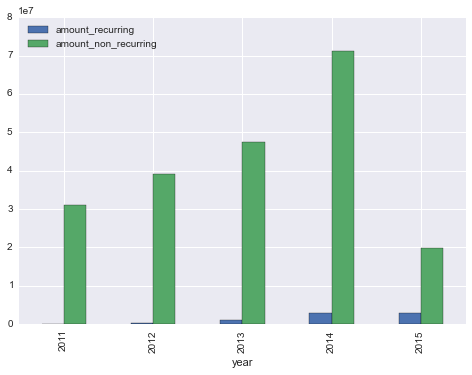

In [24]:
r3.applymap(lambda x : float(x)).plot(kind='bar')

# Estimate Future Recurring Donation Revenue

The maximum revenue we can expect is for every active recurring donor to continue to donate for the next 12 months

In [40]:
d_active = ds[ds['terminated'] == False]
max_possible_revenue = float((d_active['total_amount'] * 12).sum())
print ("Max Possible Recurring Revenue for FS 15-16: %f" % max_possible_revenue)

Max Possible Recurring Revenue for FS 15-16: 4024776.840000


In practice, recurring donors stop donating throughout the year. A simple way to estimate the reduction in revenue due to cancellation is to see what fraction of recurring donors active at the start of last year cancelled their subscription during that year and assume that the timepoint of cancellation is uniformly distributed throughout the year. This means we expect to get a half years value of recurring donations from the donors who cancel within that year.

In [41]:
def canceled_in_fs1415(x): 
    start =  str(x['start_date'])
    end = str(x['end_date'])
    
    if start > '2014-06-01 00:00:00':
        return 0
    if end > '2015-06-01 00:00:00':
        return 0
    if end < '2014-06-01 00:00:00':
        return 0
    return 1

n_cancelled = ds.apply(canceled_in_fs1415, axis=1).sum()

In [42]:
temp = d[d['receive_date'] > '2014-05-01 00:00:00']
temp = temp[temp['receive_date'] < '2014-06-01 00:00:00']
n_active = len(set(temp['contribution_recur_id']))

In [43]:
p_cancel = (float(n_cancelled) / n_active )
expected_revenue = max_possible_revenue * (1 - p_cancel ) + max_possible_revenue * 0.5 * p_cancel
print ("Expected Recurring Revenue for FS 15-16: %f" % expected_revenue)

Expected Recurring Revenue for FS 15-16: 3646930.994010


In [44]:
p_cancel

0.187759898752486